In [10]:
#import Librerie
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  # Necessario per la visualizzazione 3D
from utils.utils_functions import Utils_functions

In [11]:
X, y = Utils_functions.load_data()

#faccio 4 procedimenti complementari, uno con i dati raw, uno con i dati normalizzati, uno con i dati standardizzati e uno con le componenti principali estratte tramite la pca, durante l'esplorazione del 
#dataset abbiamo notato come il 90% della varianza viene spiegato dalle prime 8 componenti.

#preprocesso i dati
datasets, datasets_names, pca_components = Utils_functions.process_data(X)

Numero di componenti necessarie per spiegare almeno il 90.0% della varianza: 7


/Users/alessandrococco/miniconda3/envs/analisi-pendigits/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


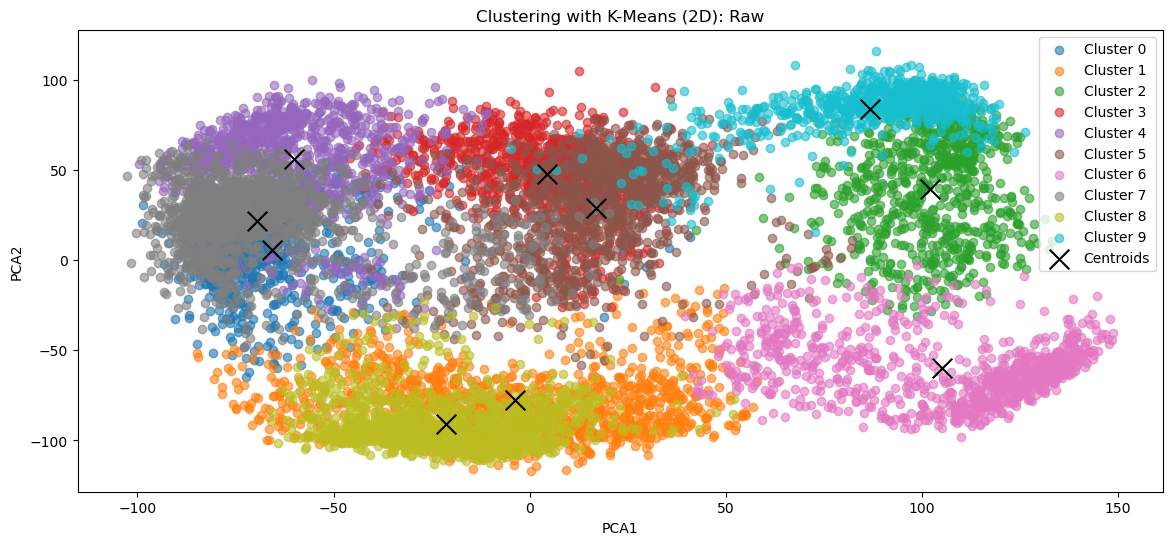

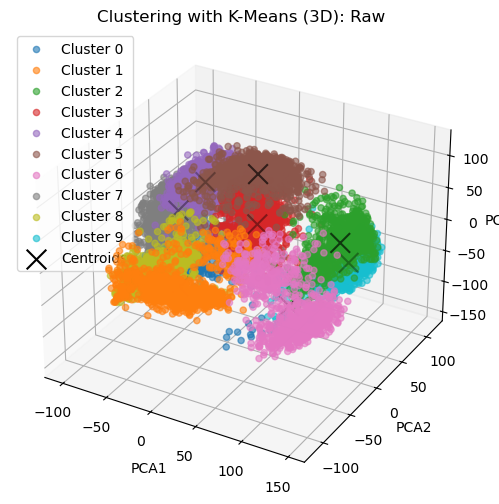

Metriche con Dataset: Raw
ARI: 0.5713618624905403
NMI: 0.6793107667348349
Homogeneity: 0.6748961234140318
Completeness: 0.6837835446237911
V-Measure: 0.6793107667348349
SSE: 50269804.41
MSE: 4573.31





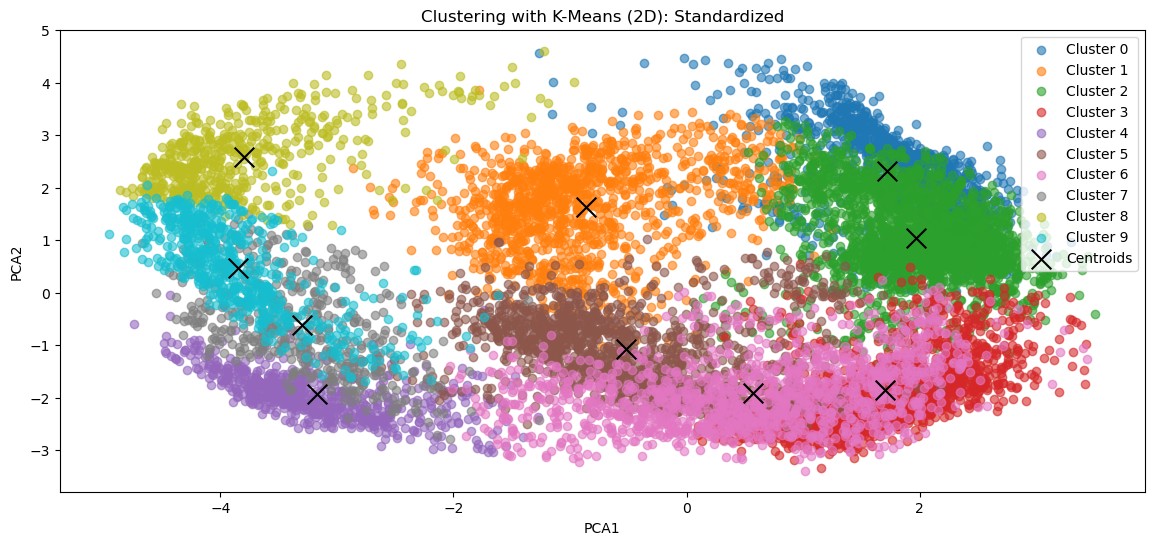

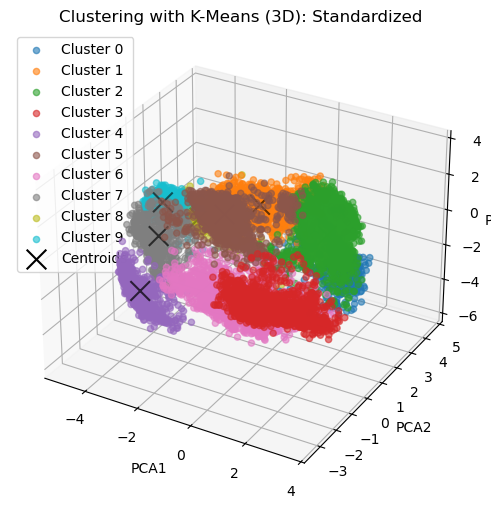

Metriche con Dataset: Standardized
ARI: 0.5411192499803225
NMI: 0.6913261688637581
Homogeneity: 0.6736782030604491
Completeness: 0.7099236357092658
V-Measure: 0.6913261688637581
SSE: 60837.62
MSE: 5.53





/Users/alessandrococco/miniconda3/envs/analisi-pendigits/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


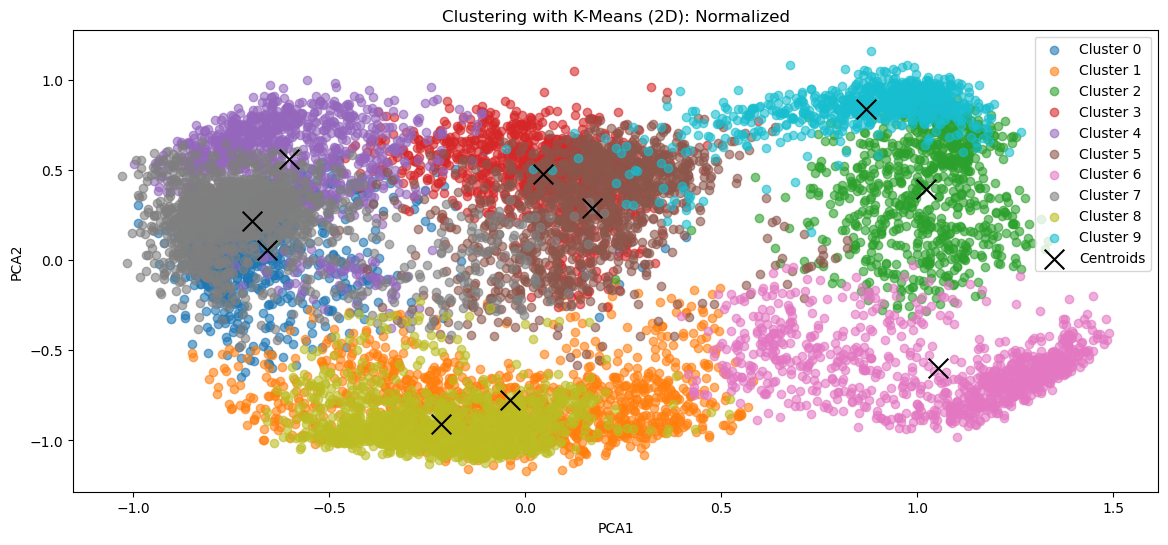

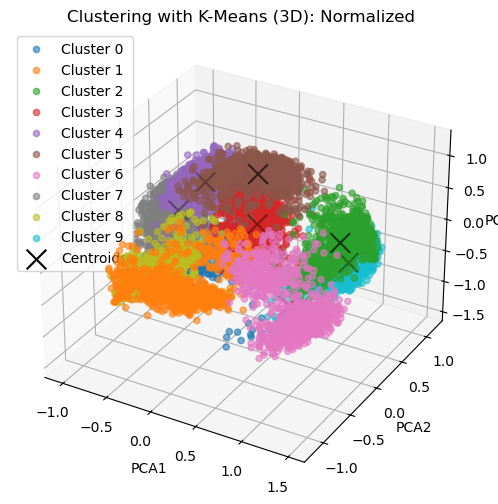

Metriche con Dataset: Normalized
ARI: 0.5713618624905403
NMI: 0.6793107667348349
Homogeneity: 0.6748961234140318
Completeness: 0.6837835446237911
V-Measure: 0.6793107667348349
SSE: 5026.98
MSE: 0.46





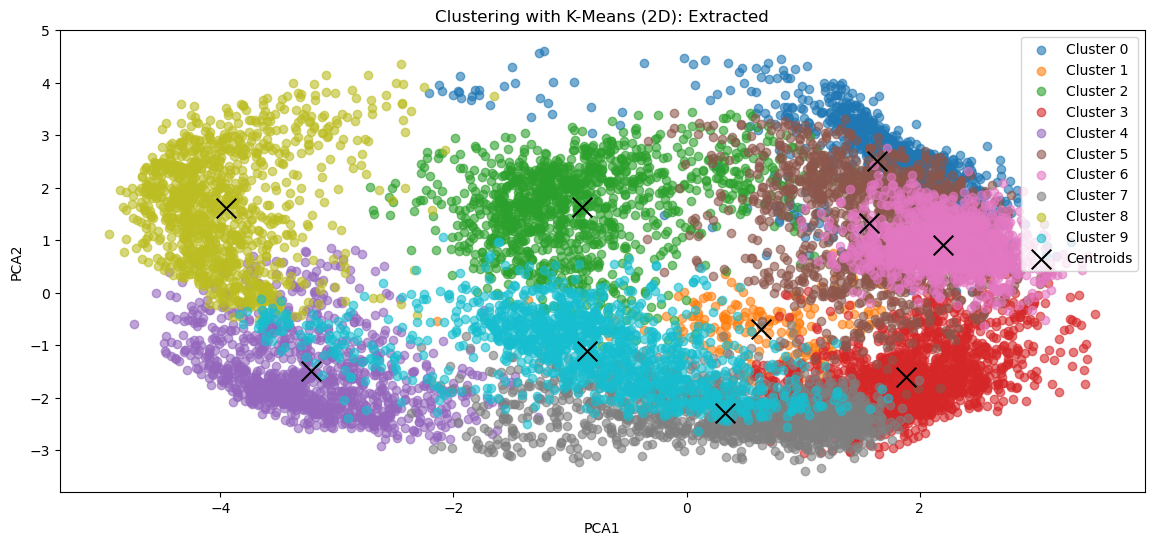

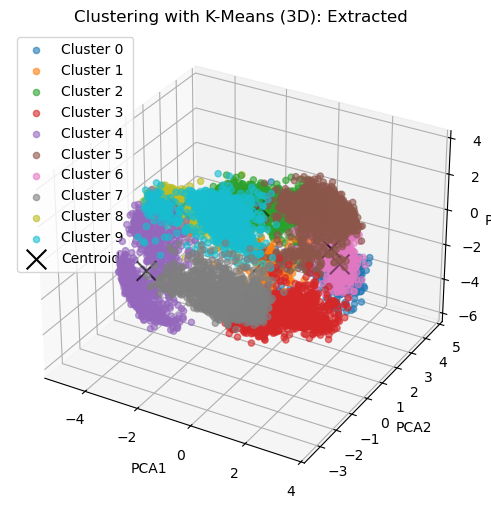

Metriche con Dataset: Extracted
PCA components: 7
ARI: 0.5157252687375341
NMI: 0.644603585240004
Homogeneity: 0.6349984318340809
Completeness: 0.6545037817016608
V-Measure: 0.644603585240004
SSE: 47040.34
MSE: 4.28





In [12]:
#colonne per PCA
columns = [f"PCA{i}" for i in range(1, pca_components + 1)]
columns_2d = columns[:2]
columns_3d = columns[:3]

#numero di cluster
num_clusters = 10

# Carico il modello KMeans
#numero di cluster = 10 perchè ci sono 10 classi nel dataset (10 cifre da 0 a 9)
kmeans = KMeans(n_clusters = num_clusters, random_state = 42, n_init = 'auto')

#per ogni dataset eseguo il k-means, plottando in 2D e 3D
for i, X in enumerate(datasets):
    
    #eseguo il k-means
    kmeans.fit(X)
    
    #assegno i labels per i plot
    labels = kmeans.labels_

    #riduzione dimensionale per i plot, tranne per il dataset in cui è già stata effetuata la PCA
    # 0: raw data; 1: normalized data; 2: standardized data; 3: PCA data
    if (i < 3):
        
        #inizializzo la PCA
        pca = PCA(n_components = pca_components)
        
        #addestro lo scaler con il dataset
        reduced_data = pca.fit_transform(X)
        
        #riduco i centroidi (senza riaddestrare lo scaler)
        reduced_centers = pca.transform(kmeans.cluster_centers_)
        
        #creo il dataframe con i dati ridotti
        df_pca = pd.DataFrame(reduced_data, columns=columns)
        
    #se il dataset è già stato ridotto con la PCA non lo riduco ulteriormente    
    else:
        
        #creo il dataframe con i dati ridotti
        df_pca = pd.DataFrame(X, columns=columns)
        
        reduced_centers = kmeans.cluster_centers_
    
    
    #aggiungo la colonna con i cluster
    df_pca['Cluster'] = kmeans.labels_
    
    #plot 2D
    plt.figure(figsize=(14, 6))
    
    for cluster in range(num_clusters):
        cluster_data = df_pca[df_pca['Cluster'] == cluster]
        plt.scatter(cluster_data[columns_2d[0]],
                    cluster_data[columns_2d[1]],
                    label=f'Cluster {cluster}', alpha=0.6)

    #centroidi in 2D
    plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1],
                marker='x', s=200, c='black', label='Centroids')
    plt.title(f'Clustering with K-Means (2D): {datasets_names[i]}')
    plt.xlabel(columns_2d[0])
    plt.ylabel(columns_2d[1])
    plt.legend()
    plt.show()


    #plot 3D
    if pca_components >= 3:
        
        fig = plt.figure(figsize=(14, 6))
        ax = fig.add_subplot(111, projection='3d')
        
        for cluster in range(num_clusters):
            
            cluster_data = df_pca[df_pca['Cluster'] == cluster]
            ax.scatter(cluster_data[columns_3d[0]],
                       cluster_data[columns_3d[1]],
                       cluster_data[columns_3d[2]],
                       label=f'Cluster {cluster}', alpha=0.6)
            
        #centroidi in 3D
        ax.scatter(reduced_centers[:, 0], reduced_centers[:, 1], reduced_centers[:, 2],
                   marker='x', s=200, c='black', label='Centroids')
        ax.set_title(f'Clustering with K-Means (3D): {datasets_names[i]}')
        ax.set_xlabel(columns_3d[0])
        ax.set_ylabel(columns_3d[1])
        ax.set_zlabel(columns_3d[2])
        ax.legend()
        plt.show()

    #calcolo delle metriche
    ari = adjusted_rand_score(y, labels)
    nmi = normalized_mutual_info_score(y, labels)
    hom = homogeneity_score(y, labels)
    comp = completeness_score(y, labels)
    vms = v_measure_score(y, labels)
    
    #calcolo SSE e MSE
    sse = Utils_functions.compute_SSE(X, labels)
    mse = sse / X.shape[0]

    print(f"Metriche con Dataset: {datasets_names[i]}")
    
    if i == 3:
        print(f"PCA components: {pca_components}")
    
    print(f"ARI: {ari}")
    print(f"NMI: {nmi}")
    print(f"Homogeneity: {hom}")
    print(f"Completeness: {comp}")
    print(f"V-Measure: {vms}")
    print(f"SSE: {sse:.2f}")
    print(f"MSE: {mse:.2f}\n")
    print("\n")
